**Name:**  Don Price<br>
**Class:** DSC 540<br>
**Assignment:** Final Project, Milestone 5

In [129]:
# Load Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json

# Milestone 2: Data Manipulation of Flat File

## National Flood Insurance Program (NFIP) Claims: 
- Loss information is tracked for each policy issued by the NFIP. Total losses per claim are provided, and there are additional policy attributes that will help us assess the total insured losses per unit of covered risk.
- Data retrieved: 4/22/2022
- This data set is available through an API and csv. We will use the csv flat file for this project. Link to data: https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v1
- Data dictionary can also be found at the link above.

In [2]:
# Load data set

FILE = 'FimaNfipClaims.csv'
DATES = ['asOfDate', 'dateOfLoss', 'originalConstructionDate', 'originalNBDate']

claims_df = pd.read_csv(FILE, parse_dates=DATES)

In [3]:
# Verify the data frame is ingested properly
claims_df.head()

,agricultureStructureIndicator,asOfDate,baseFloodElevation,basementEnclosureCrawlspace,reportedCity,condominiumIndicator,policyCount,countyCode,communityRatingSystemDiscount,dateOfLoss,...,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,reportedZipcode,primaryResidence,id
0,0.0,2021-11-21 00:34:48.052000+00:00,50.0,NaN,Temporarily Unavailable,N,1.0,48201.0,5.0,2001-06-09 04:00:00+00:00,...,1.0,1,0.0,TX,25000.0,25000.0,2001,77025.0,1.0,622850f871781e79466e63c9
1,0.0,2021-07-25 01:39:04.381000+00:00,NaN,1.0,Temporarily Unavailable,N,1.0,24033.0,5.0,2007-01-01 05:00:00+00:00,...,0.0,7,0.0,MD,100000.0,40000.0,2007,20745.0,1.0,622850f871781e79466e63c6
2,0.0,2021-07-25 01:39:04.381000+00:00,NaN,NaN,Temporarily Unavailable,N,1.0,48201.0,7.0,2006-06-19 04:00:00+00:00,...,1.0,7,0.0,TX,150000.0,60000.0,2006,77015.0,1.0,622850f871781e79466e63da
3,0.0,2021-07-25 01:39:04.381000+00:00,NaN,NaN,Temporarily Unavailable,N,1.0,48439.0,8.0,1992-06-28 04:00:00+00:00,...,0.0,7,0.0,TX,20000.0,5000.0,1992,76112.0,0.0,622850f871781e79466e63e6
4,0.0,2021-07-25 01:39:04.381000+00:00,NaN,NaN,Temporarily Unavailable,N,1.0,34001.0,5.0,1995-12-19 05:00:00+00:00,...,0.0,1,0.0,NJ,250000.0,100000.0,1995,8406.0,0.0,622850f871781e79466e63ee


In [4]:
# Provide list of fields and field types
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568936 entries, 0 to 2568935
Data columns (total 40 columns):
 #   Column                                      Dtype              
---  ------                                      -----              
 0   agricultureStructureIndicator               float64            
 1   asOfDate                                    datetime64[ns, UTC]
 2   baseFloodElevation                          float64            
 3   basementEnclosureCrawlspace                 float64            
 4   reportedCity                                object             
 5   condominiumIndicator                        object             
 6   policyCount                                 float64            
 7   countyCode                                  float64            
 8   communityRatingSystemDiscount               float64            
 9   dateOfLoss                                  datetime64[ns, UTC]
 10  elevatedBuildingIndicator                   float64   

### Cleaning Step 1: Convert Indicators to Objects instead of float variables.

Some of the indicators and the year of loss variable were converted to float values upon import. This will create issues within our model and need to be converted to objects.

In [5]:
# Convert indicator fields from float to objects.
INDICATORFIELDS = ['agricultureStructureIndicator', 'countyCode', 'elevatedBuildingIndicator',
                   'houseWorship', 'nonProfitIndicator', 'occupancyType', 'obstructionType',
                   'postFIRMConstructionIndicator', 'yearOfLoss', 'reportedZipcode',
                   'primaryResidence', 'smallBusinessIndicatorBuilding']

for x in INDICATORFIELDS:
    claims_df[x] = claims_df[x].astype('object')

In [6]:
# Verify fields were converted to floats.
claims_df[INDICATORFIELDS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568936 entries, 0 to 2568935
Data columns (total 12 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   agricultureStructureIndicator   object
 1   countyCode                      object
 2   elevatedBuildingIndicator       object
 3   houseWorship                    object
 4   nonProfitIndicator              object
 5   occupancyType                   object
 6   obstructionType                 object
 7   postFIRMConstructionIndicator   object
 8   yearOfLoss                      object
 9   reportedZipcode                 object
 10  primaryResidence                object
 11  smallBusinessIndicatorBuilding  object
dtypes: object(12)
memory usage: 235.2+ MB


### Cleaning Step 2: Filtering on Commercial Policies

Our data set will be joined to other information from the NFIP and to a listing of household statistics. To have comparable information, our claims data will need to exclude all commercial policies. We will exclude commercial policies using several of the fields within the data set.

In [7]:
# Exclude all agriculture buildings. 372 rows excluded.

pers_claims_df = claims_df.loc[claims_df['agricultureStructureIndicator']!=1]

In [8]:
# Exclude Houses of Worship. Approximately 2700 rows excluded. 

pers_claims_df = pers_claims_df.loc[pers_claims_df['houseWorship']!=1]

In [9]:
# Exclude non-profit organizations. 1967 records to remove.

pers_claims_df = pers_claims_df.loc[pers_claims_df['nonProfitIndicator']!=1]

Documentation of the Occupancy Type Code:<br>
Code indicating the use and occupancy type of the insured structure. One-digit code: 1: Single family residence; 2: 2 to 4 unit residential building; 3: Residential building with more than 4 units; 4: Non-residential building; 11: Single-family residential building with the exception of a mobile home or a single residential unit within a multi-unit building; 12: A residential non-condo building with 2, 3, or 4 units seeking insurance on all units; 13: A residential non-condo building with 5 or more units seeking insurance on all units; 14: Residential mobile/manufactured home; 15: Residential condo association seeking coverage on a building with one or more units; 16: Single residential unit within a multi-unit building; 17: Non-residential mobile/manufactured home; 18: A non-residential building; 19: A non-residential unit within a multi-unit building                                                        

In [10]:
# Using Occupancy Type field, remove all non-residential structures (occupancy codes>=17). Remove 332 rows.

pers_claims_df = pers_claims_df.loc[pers_claims_df['occupancyType']<17]

In [11]:
print(f'The original database contained {claims_df.shape[0]} records.')
print(f'Excluding commercial accounts, the personal database contains {pers_claims_df.shape[0]} records.')
print(f'There were {claims_df.shape[0] - pers_claims_df.shape[0]} records removed.')

The original database contained 2568936 records.
Excluding commercial accounts, the personal database contains 2563487 records.
There were 5449 records removed.


### Cleaning Step 3: Remove all columns with high percentage of null values

In [12]:
# Check for null values. Print any columns with null values and the number of null values.

Field = []
Null_Count = []
Null_Percent = []

for x in pers_claims_df.columns:
    null_count = sum(pers_claims_df[x].isnull())
    if null_count>0:
        Field.append(x)
        Null_Count.append(null_count)
        Null_Percent.append(null_count/(pers_claims_df.shape[0]))

nulls_df = pd.DataFrame({'Field':Field, 'Null_Count':Null_Count, 'Null_Percent':Null_Percent})
print(nulls_df.sort_values(by='Null_Count', ascending=False).head(15))

                                         Field  Null_Count  Null_Percent
18  amountPaidOnIncreasedCostOfComplianceClaim     2489195      0.971019
11                         lowestAdjacentGrade     2102968      0.820354
5                elevationCertificateIndicator     1977239      0.771308
0                           baseFloodElevation     1955040      0.762649
6                          elevationDifference     1881463      0.733947
1                  basementEnclosureCrawlspace     1794714      0.700107
17                   amountPaidOnContentsClaim     1583060      0.617542
13                             obstructionType     1072138      0.418234
4                communityRatingSystemDiscount      933363      0.364099
16                   amountPaidOnBuildingClaim      664788      0.259330
8                                    floodZone      143090      0.055819
7                                  censusTract      137866      0.053781
23                             reportedZipcode     

The top field not populated is the 'amountPaidOnIncreasedCost of ComplianceClaim'. This field represents payment of a government subsidy to allow for building improvements to mitigate future flood loss. The payment is rare, but it's a relevant cost of claim, so we will retain this field in our data.

There are 5 other fields that have 70% or more of missing values. These fields are all property descriptors. Given the sparce data and the vast difference in properties included in this data set, we will remove these columns rather than impute values.

In [13]:
# Drop columns where missing value percentage is 70% or greater (excluding payment field noted above).
DROPFIELDS = ['lowestAdjacentGrade', 'elevationCertificateIndicator', 'baseFloodElevation', 
               'elevationDifference', 'basementEnclosureCrawlspace']

try:
    pers_claims_df = pers_claims_df.drop(DROPFIELDS, axis=1)
except: 
    pass

# Confirm revised dataframe has 35 columns after drop.
print(f'Claims_df now has {pers_claims_df.shape[1]} columns. 35 columns are expected')

Claims_df now has 35 columns. 35 columns are expected


### Cleaning Step 4: Remove Fields with no Meaningful Attributes

In [14]:
# The id field is random id that is only used for FIMA's purposes. It is not usable to link to other data sets or for 
# information about the claim. Delete field.

try:
    pers_claims_df = pers_claims_df.drop('id', axis=1)
except: 
    pass

In [15]:
# The reported city field is populated with a "Temporarily Unavailable" value. Delete field.

try:
    pers_claims_df = pers_claims_df.drop('reportedCity', axis=1)
except: 
    pass

In [16]:
# Confirm the database removed two fields. The dataframe should have 33 columns.

print(f'Claims_df now has {pers_claims_df.shape[1]} columns. 33 columns are expected')

Claims_df now has 33 columns. 33 columns are expected


### Cleaning Step 5: Create a Total Paid Loss Variable

The claims data splits claims payments into 3 categories - building losses, contents losses, and government special payments. Most analysis will likely focus on a total, so this step adds a total loss column comprised of the 3 loss components.

In [17]:
# Replace NaN values with zeros for the 3 payment fields.

pers_claims_df['amountPaidOnBuildingClaim'] = pers_claims_df['amountPaidOnBuildingClaim'].fillna(0)
pers_claims_df['amountPaidOnContentsClaim'] = pers_claims_df['amountPaidOnContentsClaim'].fillna(0)
pers_claims_df['amountPaidOnIncreasedCostOfComplianceClaim'] = pers_claims_df['amountPaidOnIncreasedCostOfComplianceClaim'].fillna(0)

In [18]:
# Create total loss field.

pers_claims_df['Total_Loss'] = pers_claims_df['amountPaidOnBuildingClaim'] + pers_claims_df['amountPaidOnContentsClaim'] +\
                               pers_claims_df['amountPaidOnIncreasedCostOfComplianceClaim']

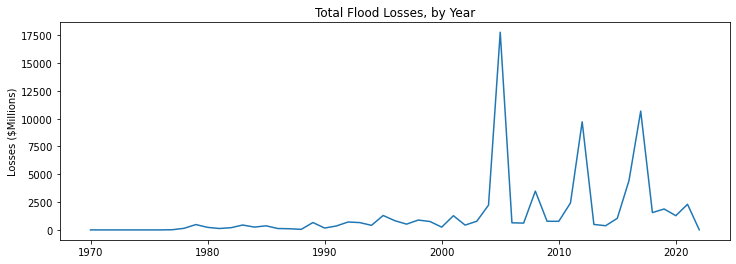

In [19]:
# Display the losses by year to help validate the transformation.
plt.figure(figsize=(12,4))
loss_year_df = pers_claims_df.groupby('yearOfLoss', as_index=False)['Total_Loss'].sum()

plt.plot(loss_year_df['yearOfLoss'], loss_year_df['Total_Loss']/1000000);
plt.title('Total Flood Losses, by Year');
plt.ylabel('Losses ($Millions)');

Based on the information from the Insurance Institute, the large losses in 2005, 2012, and 2017 are the result of certain events.

Top 10 Most Significant Flood Events By National Flood Insurance Program Payouts (1)

|Rank|Date	    | Event	     | Claim No.| Amount paid(M)	| Average paid loss |
|---|---      | ---              |---       |---              |---                |
|1 |Aug. 2005|	Hurricane Katrina|	168,256|16,092|     	95,640|
|2 |	Sep. 2017|	Hurricane Harvey|	78,254|	9,171|	117,192|
|3 |	Oct. 2012|	Superstorm Sandy|	132,897|	8,619|	64,852|
|4 |	Sep. 2008|	Hurricane Ike|	47,247|	2,670|	56,517|
|5 |	Aug. 2016|	Louisiana severe storms and flooding|	27,737|	2,536|	91,432|
|6 |	Sep. 2004|	Hurricane Ivan|	31,981|	1,688|	52,791|
|7 |	Sep. 2021|	Hurricane Ida|	28,544|	1,589|	55,658|
|8 |	Sep. 2004|	Hurricane Jeanne|	31,486|	1,513|	48,062|
|9 |Aug. 2011|	Hurricane Irene|	44,178|	1,321|	29,894|
|10|	Sep. 2017|	Hurricane Irma|	23,119|	1,153|	49,884|


(1) Includes events from 1978 to December 31, 2021 as of March 9, 2022. Defined by the National Flood Insurance Program as an event that produces at least 1,500 paid losses. Stated in dollars when occurred.

### Step 6: Filter data to Texas Claims Only

In [52]:
# Filter on TX only claims.
tx_claims_df = pers_claims_df.loc[pers_claims_df['state']=='TX']

In [57]:
# Validate df.
print(f'Shape of personal df (all states): {pers_claims_df.shape}')
print(f'Shape of TX Only df: {tx_claims_df.shape}')

Shape of personal df (all states): (2563487, 34)
Shape of TX Only df: (391291, 34)


In [59]:
# Validate only TX claims remain.
tx_claims_df['state'].value_counts()

TX    391291
Name: state, dtype: int64

# Milestone 3: Manipulation of a Table Scrapped from a Website

## Unites States Housing Units: 
- Housing unit counts are listed for each county in the state. A housing unit will be defined as any distinct unit with a separate eating and living quarters.
- Data Link: https://www.indexmundi.com/facts/united-states/quick-facts/illinois/housing-units#table 
- The tables are split by state, so we will need to scrape each website page to get the housing statistics for the entire US. Starting with 2 states first.

The housing units counts are only provided for a county. The table does not list a state, which we will append. Our NFIP data contains a FIPS code, which is a unique code for a particular county and state combination. Once we have the table of housing counts, we will need to append the FIPS code (obtained from the government website). FIPS will be the key used to join the housing data to our claims and policy data.

In [130]:
# Write a function to scrape data from the housing website. Each state has it's on url.

def state_weblist(state):
    URL = 'https://www.indexmundi.com/facts/united-states/quick-facts/'+state+'/housing-units#table'
    try:
        list_of_tables = pd.read_html(URL)
        return list_of_tables[0]
    except:
        print(f'Printing of {state} table failed.')

#### Step 1: Pull table and append state value.

In [131]:
# Identify two states for retreival. The dictionary value is used in the url to publish.

state = {'il': 'illinois',
         'mo': 'missouri',
         'tx': 'texas'}

# Create empty dataframe to store housing data.
housing_df = pd.DataFrame()

for key, value in state.items():
    df = state_weblist(value)
    df['state'] = key
    housing_df = housing_df.append(df)

In [132]:
# Check table by summarizing results by state.

housing_df.groupby('state').count()

,County,Value
state,,
il,102,102
mo,114,114
tx,254,254


#### Step 2: Change State to Uppercase for Appending to FIPS

In [133]:
# Change state field to uppercase.

housing_df['state'] = housing_df['state'].str.upper()

In [134]:
# Validate state field is uppercase.

housing_df.head()

,County,Value,state
0,Adams,30278,IL
1,Alexander,3977,IL
2,Bond,7286,IL
3,Boone,20097,IL
4,Brown,2451,IL


#### Step 3: Rename State Field for Case Consistency

In [135]:
# Rename 'state' column to title case and rename 'value' to 'Housing_Counts'.
housing_df = housing_df.rename(columns={'state': 'State', 'Value': 'Housing_Counts'})

In [136]:
# Verify
housing_df.head()

,County,Housing_Counts,State
0,Adams,30278,IL
1,Alexander,3977,IL
2,Bond,7286,IL
3,Boone,20097,IL
4,Brown,2451,IL


#### Step 4: Load FIPS file and append fips field.

In [137]:
# Load fips data

FILE = 'fips_code.csv'

fips_df = pd.read_csv(FILE, names=['FIPS','County', 'State'], header=0)

In [138]:
# Verify fips df load.

fips_df.head()

,FIPS,County,State
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL


In [139]:
# Merge FIPS to our list of housing counts by county and state.

housing_df1 = housing_df.merge(fips_df, how='left', on=['County', 'State'])

In [140]:
# Verify proper merge of fips to our housing values data set.

housing_df1.head()

,County,Housing_Counts,State,FIPS
0,Adams,30278,IL,17001
1,Alexander,3977,IL,17003
2,Bond,7286,IL,17005
3,Boone,20097,IL,17007
4,Brown,2451,IL,17009


In [141]:
# Verify no blank fips codes.
housing_df1.isnull().sum()

County            0
Housing_Counts    0
State             0
FIPS              0
dtype: int64

#### Step 5: Change Type of FIPS to String from a Number

In [142]:
# Check dtype of housing dataframe.
housing_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470 entries, 0 to 469
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   County          470 non-null    object
 1   Housing_Counts  470 non-null    int64 
 2   State           470 non-null    object
 3   FIPS            470 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 18.4+ KB


In [143]:
# FIPS is not an integer. Need to convert type to object.

housing_df1['FIPS'] = housing_df1['FIPS'].astype('object')

# Verify output is whole value and does not contain decimals.

housing_df1['FIPS']

0      17001
1      17003
2      17005
3      17007
4      17009
       ...  
465    48499
466    48501
467    48503
468    48505
469    48507
Name: FIPS, Length: 470, dtype: object

# Milestone 4: Manipulating Data Source from API

## National Flood Insurance Program (NFIP) Policies: 
- This data provides a listing of all policies issued by the government-run flood program, the NFIP. The data includes information about the location and building descriptors for each covered policy. Pricing per policy is also included, which will aid in the assessment of risk (higher average prices are likely to occur in areas with high flood risk).
- This data set is available through an API and csv. We will use the API for this project. 
- The file is available here: https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v1

In pulling the data, there are certain parameters we need to adjust to get the data. URL parameters include:
- "\$metadata=off": Removes metadata at the start of the json return.
- "\$select": This allows us to select which fields we return in our dataframe. Because some overlap with claims data, we will only return certain fields.
- "\$skip=x": The API only allows for 1000 records to be run at a time. We will need to write a function to iterate API calls to ensure we return all rows in our data.
- "\$filter=x": Limiting our data to TX and for years after 2018. The API call is very slow so the project will need to be scaled down to avoid large run times.

In [112]:
# Run query of the NFIP policy database, using Requests library. Parameters are noted above.

base_url = "https://www.fema.gov/api/open/v1/FimaNfipPolicies"
no_meta = "$metadata=off"
select_fields = "$select=countyCode,policyEffectiveDate,policyCost,policyCount,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,totalInsurancePremiumOfThePolicy"
filter_cols="$filter=(propertyState eq'TX' and policyEffectiveDate ge'2018-01-01T01:00:00.000z')"

# Create request string of repeated parameters
URL = base_url+"?"+filter_cols+"&"+select_fields+"&"+no_meta

In [113]:
# Write a function to iterate API calls in chunks of 1000 (which is API limit)

def API_call(records=10000):
    '''
    The function will iterate API calls, pulling 1000 records at a time. Records will be appended
    to the full_records dataframe. Error checking will be in place: API call errors will return a note
    informing users to rerun while any missing chunks will be counted and printed for users. Large
    chunks should be rerun.
    '''
    columns = ['countyCode','policyEffectiveDate','policyCost','policyCount','totalBuildingInsuranceCoverage',
                       'totalContentsInsuranceCoverage','totalInsurancePremiumOfThePolicy']    
    full_records = pd.DataFrame(columns=columns)
    error_count = 0
    skip_count = 0
    
    while skip_count < records:
            
        try:
            chunk = requests.get(URL+'&$skip='+str(skip_count))
            if chunk.status_code==200:
                nfip_chunk = chunk.json()['FimaNfipPolicies']    # Filter applied to get to second level where data is stored.
                nfip_df = pd.DataFrame(nfip_chunk)
                full_records = pd.concat((full_records, nfip_df), axis=0, ignore_index=True)
            else:
                error_count+=1

        except:
            print("Something went wrong. Try again")
        
        # Increase count by 1000 to pull next chunk.
        skip_count += 1000

    # Communicate any errors that occurred during load.
    print(f'Number of errors: {error_count}')
    
    # Return dataframe for use.
    return full_records

In [114]:
# Run the API_call function to capture all records.
db_records = 21830597

policies_df = API_call(records=2500000)

Number of errors: 0


In [115]:
# Verify data has been imported properly.

policies_df.head()

,countyCode,policyEffectiveDate,policyCost,policyCount,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,totalInsurancePremiumOfThePolicy,id
0,48039,2018-01-01T05:00:00.000Z,574,1,100000,40000,260,62793b769281a24e2b3d205c
1,48167,2018-01-01T05:00:00.000Z,450,1,250000,100000,348,62793b809281a24e2b3dfe6d
2,48167,2018-01-01T05:00:00.000Z,425,1,200000,80000,326,62793b809281a24e2b3e08f4
3,48201,2018-01-01T05:00:00.000Z,450,1,250000,100000,348,62793b879281a24e2b3e9eb7
4,48485,2018-01-01T05:00:00.000Z,1032,1,83400,9600,832,62793b8d9281a24e2b3f232c


In [116]:
# Determine full shape of dataframe
policies_df.shape

(2500000, 8)

#### Step 1: Convert ID to count. We will use this to count policies in force.

In [117]:
# Set all values to 1. We will sum these when aggregating this data set.

policies_df['id'] = 1

#### Step 2: Change column title of 'id' to reflect new value

In [118]:
# Call new column policy count, and change old column to reflect that it's units per policy.

policies_df.rename(columns = {'id': 'Policy_Sold_Count',
                              'policyCount': 'Units_Per_Policy',
                              'totalBuildingInsuranceCoverage': 'Building_Limits_Purchased',
                              'countyCode': 'County_Code',
                              'totalContentsInsuranceCoverage': 'Contents_Limits_Purchased',
                              'totalInsurancePremiumOfThePolicy': 'Policy_Insurance_Premium',
                              'policyCost': 'Total_Policy_Insurance_Cost'},
                   inplace=True)

# Verify new names.
policies_df.columns

Index(['County_Code', 'policyEffectiveDate', 'Total_Policy_Insurance_Cost',
       'Units_Per_Policy', 'Building_Limits_Purchased',
       'Contents_Limits_Purchased', 'Policy_Insurance_Premium',
       'Policy_Sold_Count'],
      dtype='object')

#### Step 3: Change Effective Date to Year

In [119]:
# Effective date is stored as an object. Change type to datetime.

policies_df['policyEffectiveDate'] = pd.to_datetime(policies_df['policyEffectiveDate'])

In [120]:
# Create a year field from effective date field.

policies_df['Policy_Effective_Year'] = policies_df['policyEffectiveDate'].dt.year

#### Step 4: Drop Effective Date Column

In [121]:
# Drop redundant effective date.

try:
    policies_df.drop('policyEffectiveDate', axis=1, inplace=True)
except:
    print('Dropped column did not execute.')

#### Step 5: Change Numerical Columns to Float

In [122]:
num_cols = ['Total_Policy_Insurance_Cost', 'Units_Per_Policy', 'Building_Limits_Purchased', 
            'Contents_Limits_Purchased', 'Policy_Insurance_Premium']

for c in num_cols:
    policies_df[c] = policies_df[c].astype('float')

In [123]:
# Verify correct fields and types are in our dataframe.
policies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 8 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   County_Code                  object 
 1   Total_Policy_Insurance_Cost  float64
 2   Units_Per_Policy             float64
 3   Building_Limits_Purchased    float64
 4   Contents_Limits_Purchased    float64
 5   Policy_Insurance_Premium     float64
 6   Policy_Sold_Count            int64  
 7   Policy_Effective_Year        int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 152.6+ MB


#### Step 6: Group Data by County and Year

In [124]:
# Group dataframe for consolidation with other sources.

grouped_policy_df = policies_df.groupby(['County_Code', 'Policy_Effective_Year'], as_index=False)\
                               .agg({'Total_Policy_Insurance_Cost': np.mean,
                                     'Units_Per_Policy': np.sum,
                                     'Building_Limits_Purchased': np.sum,
                                     'Contents_Limits_Purchased': np.sum,
                                     'Policy_Insurance_Premium': np.mean,
                                     'Policy_Sold_Count': np.sum,
                                    })

In [125]:
# Verify grouped data.

grouped_policy_df.head()

,County_Code,Policy_Effective_Year,Total_Policy_Insurance_Cost,Units_Per_Policy,Building_Limits_Purchased,Contents_Limits_Purchased,Policy_Insurance_Premium,Policy_Sold_Count
0,,2018,1042.370764,2031.0,4.015018e+08,139701200.0,775.486596,1977
1,,2019,982.291101,2713.0,5.652844e+08,200235000.0,734.388009,2652
2,,2020,770.583605,5575.0,1.234325e+09,466689300.0,567.490569,5514
3,,2021,807.950755,1547.0,3.460735e+08,121923900.0,594.995404,1523
4,22019,2018,591.000000,1.0,1.250000e+05,50000.0,275.000000,1


# Milestone 5: Save Processed Files to CSV

The three data sets were run and processed as documented above. Files are saved to CSV and will be picked up in the 'SQLProcessing' notebook.

In [62]:
# Print TX Claims dataframe to csv.

tx_claims_df.to_csv('tx_claims_df.csv', index=False)

In [144]:
# Print Housing Counts dataframe to csv.

housing_df1.to_csv('housing_df.csv')

In [126]:
# Print Policy Data dataframe to csv.

grouped_policy_df.to_csv('tx_policy_df.csv')